# Analysis of WaveShare TOF Sensor

The goal of this notebook is to demonstrate the accuracy of the Time of Flight (TOF) sensor by WaveShare in measuring distance. As quoted by the documentation:

> The module is affected by natural light. Generally speaking, the stronger the natural light, the greater the impact, which manifests as the shorter the ranging distance, the worse the accuracy, and the larger the fluctuation. Under strong light conditions (such as sunlight), it is generally recommended to use in close-range detection scenes.

I measured 500 points of data at every 0.5m intervals from 0.5m to 5.0m, in indoors and outdoors conditions. I will be graphing the data to demonstrate and visualize the accuracy of the sensor.

In [2]:
import pathlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from IPython.display import display

## Extracting Data

Below, I extract the first 500 points measured by the WaveShare TOF sensor at each interval of 0.5m, 1.0m, ... , 5.0m, and store it in an array. 

Afterwards, I calculate the average measured distance and the standard deviation of each interval.

In [3]:
actual_distance = [0.5 * i for i in range(1, 11)]
indoors_data = []
outdoors_data = []

# Extract indoors data.
for file in pathlib.Path('./data/indoors').iterdir():
    distance_data = pd.read_excel(file)["distance(m)"][:500]
    indoors_data.append(distance_data)

# Extract outdoors data.
for file in pathlib.Path('./data/outdoors').iterdir():
    distance_data = pd.read_excel(file)["distance(m)"][:500]
    outdoors_data.append(distance_data)

In [4]:
# Sort data in ascending order, i.e. 0.5m, 1.0m, ..., 5.0m.
indoors_data.sort(key=lambda x: np.mean(x))
outdoors_data.sort(key=lambda x: np.mean(x))

# Get average distances.
indoors_average = [np.mean(data) for data in indoors_data]
outdoors_average = [np.mean(data) for data in outdoors_data]

# Get Standard Deviations.
indoors_std = [np.std(data) for data in indoors_data]
outdoors_std = [np.std(data) for data in outdoors_data]

# Print table of data.
data = {'Actual Distance': actual_distance, 'Indoors Average': indoors_average, 'Outdoors Average': outdoors_average, 'Indoors Standard Deviation': indoors_std, 'Outdoors Standard Deviation': outdoors_std}
table = pd.DataFrame(data=data)
display(table)

,Actual Distance,Indoors Average,Outdoors Average,Indoors Standard Deviation,Outdoors Standard Deviation
0,0.5,0.519539,0.498210,0.008372,0.003008
1,1.0,1.002848,1.004984,0.006121,0.012766
2,1.5,1.503528,1.541448,0.007215,0.068946
3,2.0,2.016492,2.106750,0.004298,0.233768
4,2.5,2.499730,2.599902,0.007405,0.342084
5,3.0,3.016268,2.956278,0.021327,1.216785
6,3.5,3.516978,2.961156,0.026855,0.478762
7,4.0,4.042554,3.280780,0.145125,0.666602
8,4.5,4.056940,3.317990,1.581092,1.078911
9,5.0,4.353378,3.329556,0.229547,0.914410


## Accuracy of TOF Sensor

### Introduction

The results show a difference in the accuracy of the TOF sensor indoors and outdoors. My experiment shows that in an indoors condition, where natural light is limited, the sensor is shown to be very accurate up to 4.0m. However, in an outdoors condition, the sensor appears to be accurate only up to 3.0m. According to the documentation:

> Short range: accuracy ±1.0cm, standard deviation<0.3cm

> Mid range: accuracy ±1.0cm, standard deviation<1.5cm

> Long range: accuracy ±1.5cm, standard deviation<0.5cm@0.01~3m, standard deviation<8cm@3~5m

### Raw Data

I tested the sensor at intervals of 0.5m from 0.5m to 5.0m. At each interval, the sensor would output a list of distances measured. In the first two graphs, I plotted the mean distances measured by the sensor at each interval along with an error bar of 1 stardard deviation.

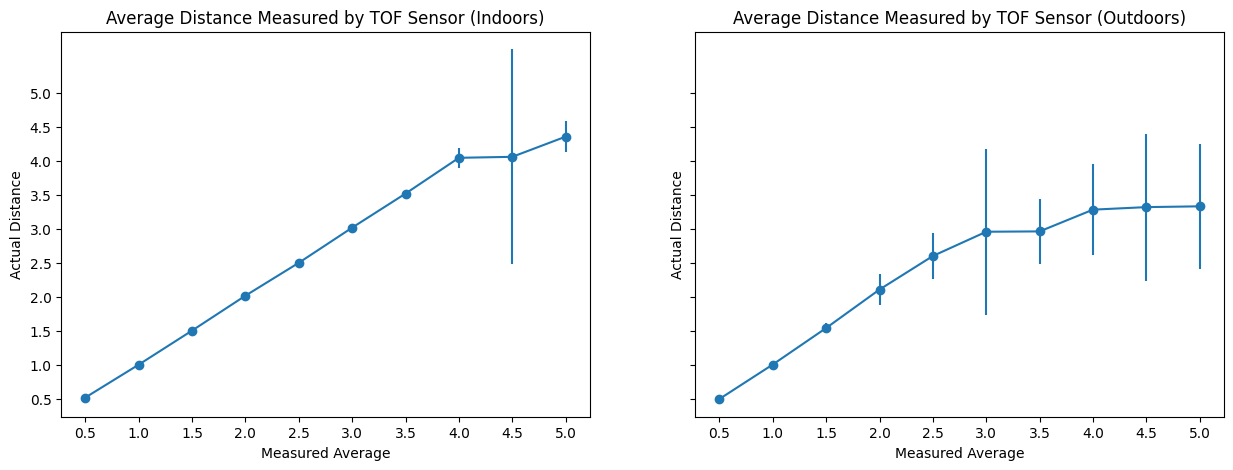

In [5]:
def plot_graph(ax, data, std, name) -> None:
    ax.set_title(f'Average Distance Measured by TOF Sensor ({name})')
    ax.set_xlabel('Measured Average')
    ax.set_ylabel('Actual Distance')
    ax.set_yticks(actual_distance)
    ax.set_xticks(actual_distance)
    ax.errorbar(actual_distance, data, yerr=std, marker='o')


fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15, 5))
plot_graph(ax0, indoors_average, indoors_std, 'Indoors')
plot_graph(ax1, outdoors_average, outdoors_std, 'Outdoors')

To visualize the spread of the data measured by the sensor, below are two scatter graphs (indoors and outdoors respectively) depicting the the distances measured by the sensor at each distance interaval. It can be seen that the sensor loses accuracy the further the distance it measures. Moreover, it greatly loses accuracy outdoors when exposed to natural light.

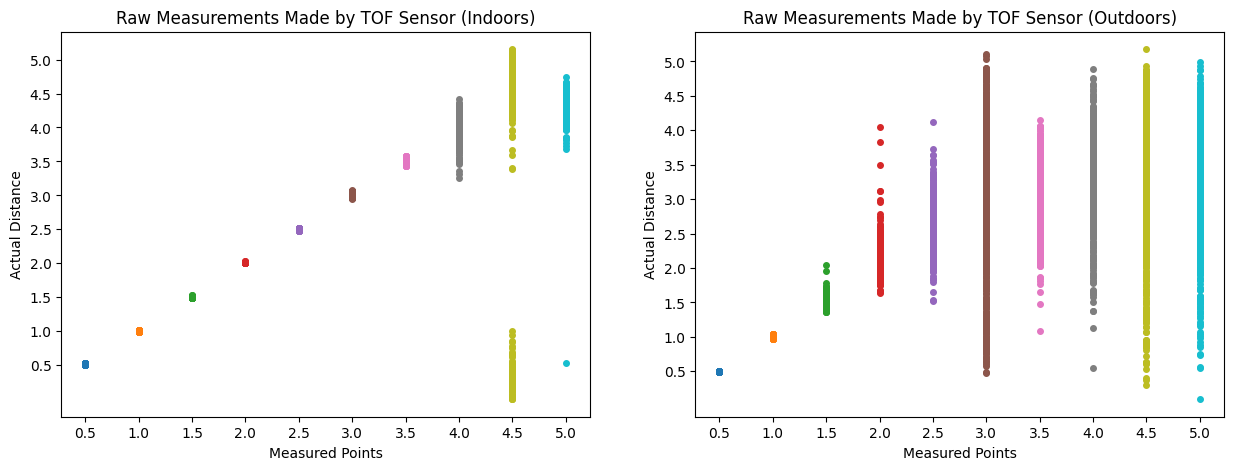

In [6]:
def plot_raw_data(ax, data, name) -> None:
    ax.set_title(f'Raw Measurements Made by TOF Sensor ({name})')
    ax.set_xlabel('Measured Points')
    ax.set_ylabel('Actual Distance')
    ax.set_yticks(actual_distance)
    ax.set_xticks(actual_distance)

    for i, distance in enumerate(actual_distance):
        ax.scatter([distance] * len(data[i]), data[i], s=16)


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_raw_data(ax[0], indoors_data, 'Indoors')
plot_raw_data(ax[1], outdoors_data, 'Outdoors')

### Processed Data

Next, I attempted to plot a best fit curve for the data. First, I removed all data that fell 1 standard deviation away at each distance interval. I then plotted the same scatter as above with the ammended data, and proceeded to plot a best fit curve. The equations are linear in nature, which thereby indicates that the sensor on average is generally accurate.

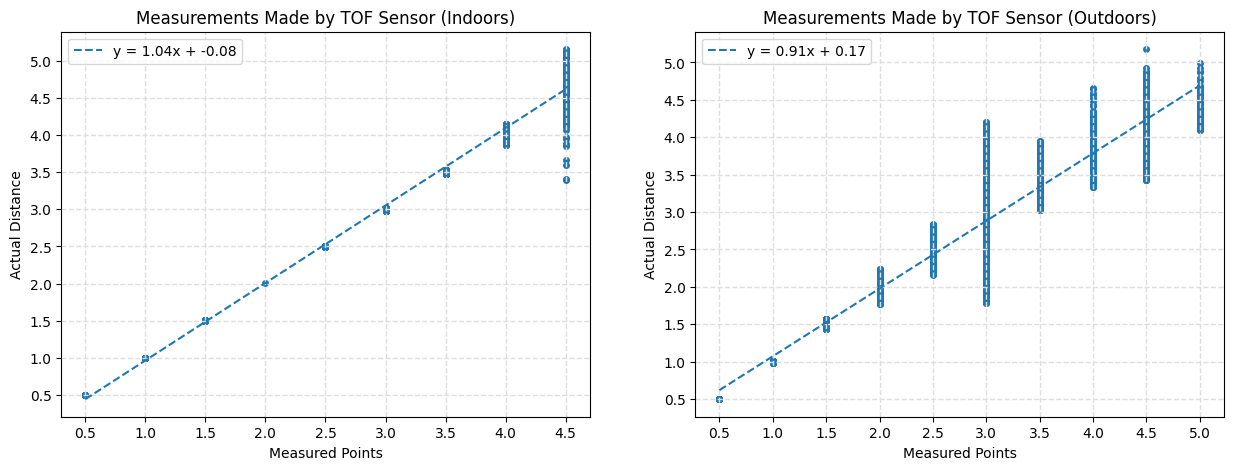

In [7]:
def plot_scatter_graph(ax, data, name) -> None:
    ax.set_title(f'Measurements Made by TOF Sensor ({name})')
    ax.set_xlabel('Measured Points')
    ax.set_ylabel('Actual Distance')
    ax.set_yticks(actual_distance)
    ax.set_xticks(actual_distance)
    ax.grid(color='#Dedede', linestyle='--', linewidth=1)

    x = []
    y = []

    for i, distance in enumerate(actual_distance):
        std = np.std(data[i])
        for actual, measured in zip([distance] * len(data[i]), data[i]):

            # Exclude point if it is greater than 1 standard deviation away.
            if abs(actual - measured) > std:
                continue
            x.append(actual)
            y.append(measured)

    ax.scatter(x, y, s=16)

    m, b = np.polyfit(x, y, 1)
    new_x = np.array(x)
    ax.plot(new_x, b + m * new_x, '--', label=f'y = {m:.2f}x + {b:.2f}')
    ax.legend()


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plot_scatter_graph(ax[0], indoors_data, 'Indoors')
plot_scatter_graph(ax[1], outdoors_data, 'Outdoors')

## Testing

### Stationary Tests

* After conducting statics tests, I set up the TOF Sensor on a Raspberry Pi 4 and mounted it on a bike to test for passing cars.
* The first set of tests was conducted with the bike stationary, and having a car drive past it at 1-2 meters.
* As can be seen from the 3rd graph, daylight severely affects the reliability of the sensor. However, after adding a 3D-printed shade, the reliability of the sensor was improved considerably, especially at night where there was no miserrant data.

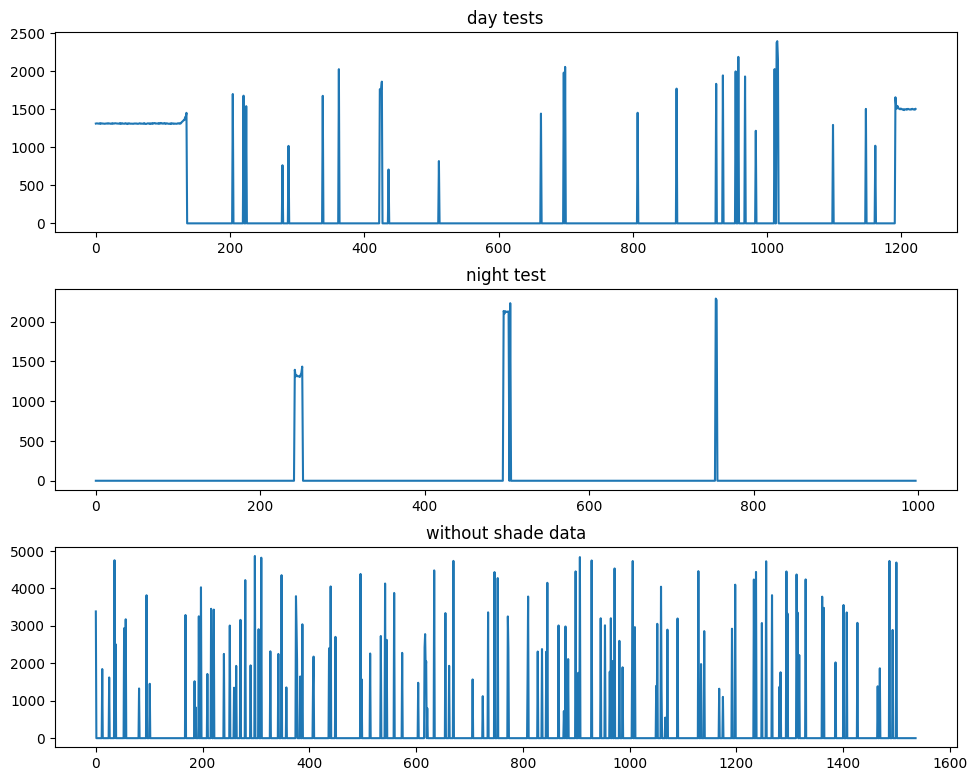

In [8]:
fig, axs = plt.subplots(3, figsize=(10, 8))
fig.tight_layout(pad=2)
data_dir = pathlib.Path('./data/tof_stationary_tests/')

for i, data_file in enumerate(data_dir.iterdir()):
    distances = []
    file_name = ' '.join(data_file.name.split(".txt")[0].split("_"))

    with open(data_file) as file:
        for distance in file.readlines():
            distances.append(int(distance))

    axs[i].plot(distances)
    axs[i].set_title(file_name)

plt.show()

* Let's try to clean up the data. We will remove all points which are not grouped together.
    * Firstly, we remove numbers which are not within 2 points from other points. This is because I noticed that the sensor will generate random points sporadically. However, when it senses an object, it tends to be consistent and points will be grouped together.
    * Secondly, we remove all points which are not within 20% of each other's value.
* The `plot_test_graphs` function will allow for easy cleaning and plotting of future data.

In [9]:
def clean_data(distances: list[int]) -> list[int]:
    """
    Given a set of points generated by the TOF sensor, clean spurious data.

    Args:
        distances (list[int]): Original list of points.

    Returns:
        list[int]: Return cleaned data.
    """
    for k, point in enumerate(distances):
        if k < len(distances) - 3 and point != -1:
            adjacent_points = [distances[j] for j in range(k - 2, k + 3) if distances[j] != -1]
            
            # Remove values which are not grouped within 2 points.
            if len(adjacent_points) <= 1:
                distances[k] = -1

            # Remove 2 points if they are not within 20% of each other.
            if len(adjacent_points) == 2:
                small, big = sorted(adjacent_points)
                if small / big < 0.8:
                    distances[k] = -1

    return distances


def is_digit(digit: str) -> bool:
    try:
        int(digit)
        return True
    except ValueError:
        return False


def plot_test_graphs(axs: mpl.axes.Axes, data_dir: pathlib.Path) -> None:
    """
    Helper function to plot test graphs.

    Args:
        axs (mpl.axes.Axes): Axes object of the graph.
        data_dir (pathlib.Path): Path object to the data directory.
    """
    for i, data_file in enumerate(data_dir.iterdir()):
        distances = []
        file_name = ' '.join(data_file.name.split(".txt")[0].split("_"))

        with open(data_file) as file:
            for distance in file.readlines():
                if is_digit(distance):
                    distances.append(int(distance))

        distances = clean_data(distances)

        axs[i].plot(distances)
        axs[i].set_title(file_name)

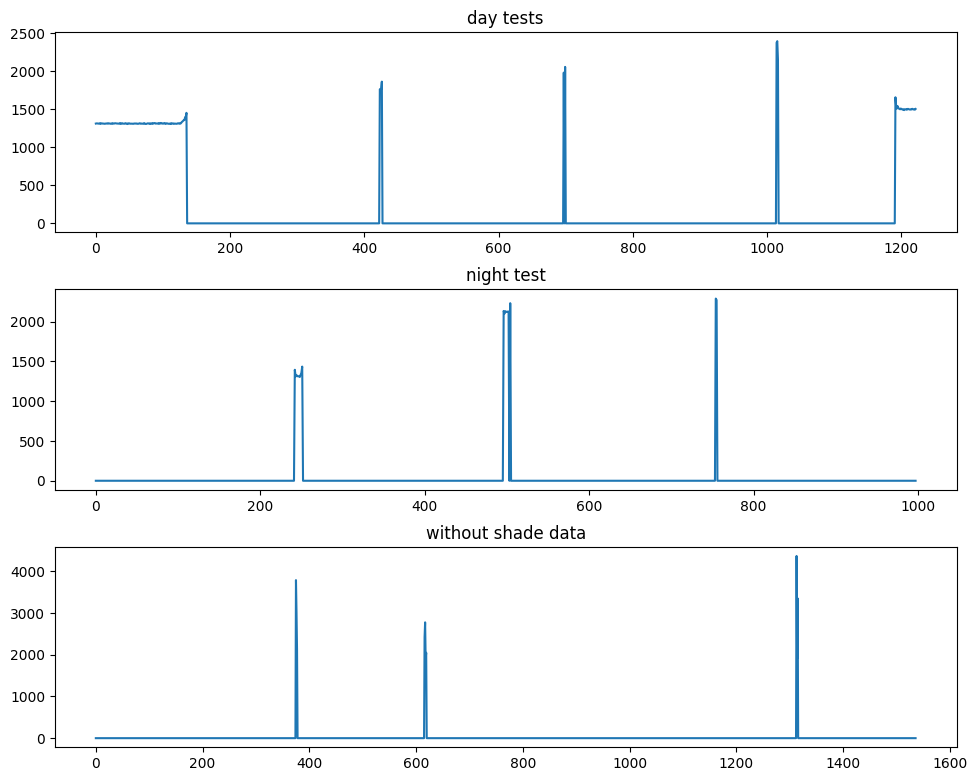

In [10]:
fig, axs = plt.subplots(3, figsize=(10, 8))
fig.tight_layout(pad=2)
data_dir = pathlib.Path('./data/tof_stationary_tests/')

plot_test_graphs(axs, data_dir)
plt.show()

### Basic Tests

* Next, we mounted the TOF sensor on the bike and proceeded to ride past some stationary cars.
* Cycling Test Indoors: We cycled the bike past some cars in the shade.
* Cycling Test Outdoors: We cycled the bike past some cars in the sun.
* Pass Car: We passed 2 stationary cars with the bike, thereby confirming the accuracy of the sensor.

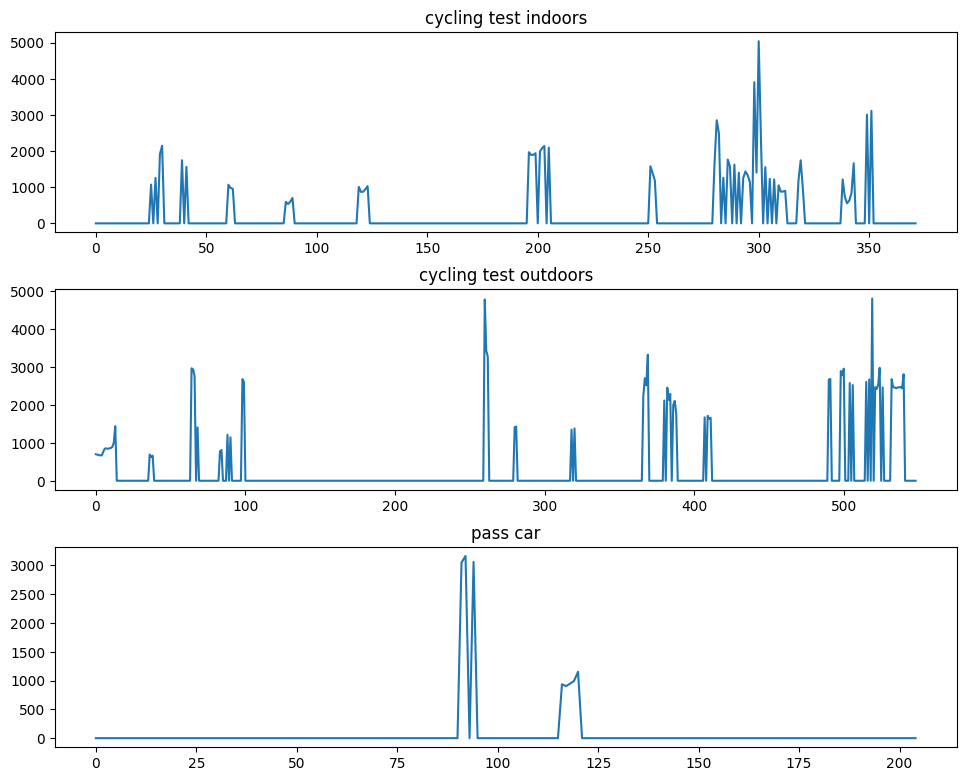

In [11]:
fig, axs = plt.subplots(3, figsize=(10, 8))
fig.tight_layout(pad=2)
data_dir = pathlib.Path('./data/tof_basic_tests/')

plot_test_graphs(axs, data_dir)
plt.show()

### Cycling Tests

#### Corporation Rd

* After redesigning the casing and updating some code, I was ready to do some real-life testing. Now, each data point is accompanied by a timestamp for better recording.
* To start, we cycled the bike along Corporation Rd where real cars would pass the cyclist and recorded all the points. The graph below shows the raw data and the cleaned data.

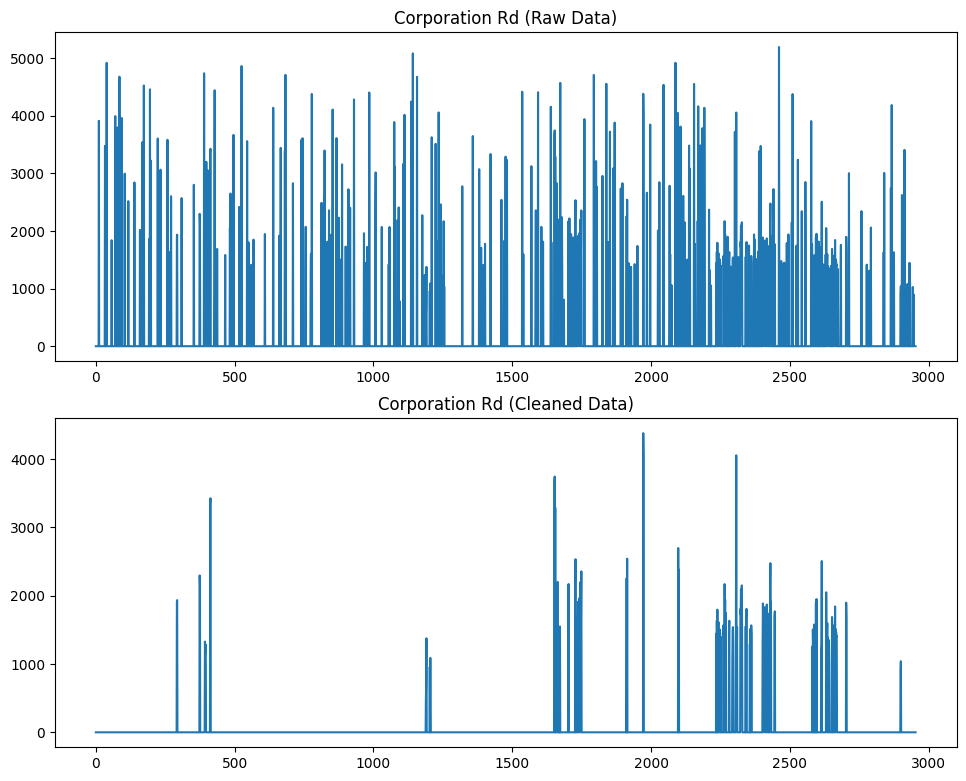

In [12]:
fig, axs = plt.subplots(2, figsize=(10, 8))
fig.tight_layout(pad=2)
raw_data = []

with open('./data/tof_cycling_tests/corporation_road.txt') as file:
    for point in file.readlines():
        point = point.rstrip()
        if point == '-1':
            raw_data.append(-1)
        else:
            t, distance = point.split(' ')
            raw_data.append(int(distance))

axs[0].plot(raw_data)
axs[0].set_title("Corporation Rd (Raw Data)")

cleaned_data = clean_data(raw_data)
axs[1].plot(cleaned_data)
axs[1].set_title("Corporation Rd (Cleaned Data)")

plt.show()

#### Lakeside Dr

Text(0.5, 1.0, 'Lakeside Dr (Cleaned Data)')

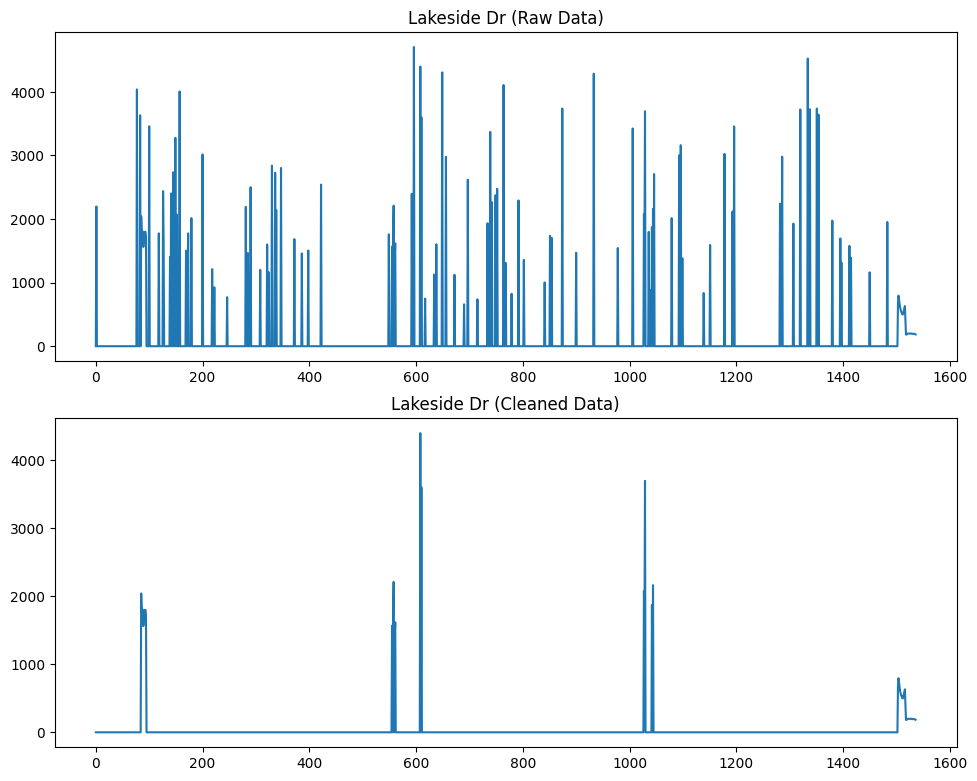

In [15]:
fig, axs = plt.subplots(2, figsize=(10, 8))
fig.tight_layout(pad=2)
raw_data = []

with open('./data/tof_cycling_tests/lakeside_drive.txt') as file:
    for point in file.readlines():
        point = point.rstrip()
        if point == '-1':
            raw_data.append(-1)
        else:
            t, distance, strength = point.split(' ')
            raw_data.append(int(distance))

axs[0].plot(raw_data)
axs[0].set_title("Lakeside Dr (Raw Data)")

cleaned_data = clean_data(raw_data)
axs[1].plot(cleaned_data)
axs[1].set_title("Lakeside Dr (Cleaned Data)")